In [4]:
pip install tqdm

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.feature import hog, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from google.colab import drive
from tqdm import tqdm


In [6]:
!ls

sample_data


In [7]:
# -------------------------------
# Configuration
# -------------------------------
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/Personal/Redes Neuronales Proyecto/Proyecto/Segunda entrega/Datasets/dataset"


CLASSES      = ["Apple__Healthy", "Apple__Rotten"]
IMG_SIZE     = (64, 64)


Mounted at /content/drive


In [8]:
import os
from PIL import Image

# Función para contar imágenes en una carpeta
def count_images_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))])

# Contar imágenes en cada clase
total_images = 0
for class_name in CLASSES:
    class_path = os.path.join(DATA_PATH, class_name)
    num_images = count_images_in_folder(class_path)
    print(f"Clase '{class_name}': {num_images} imágenes")
    total_images += num_images

print(f"Total de imágenes en el dataset: {total_images}")

Clase 'Apple__Healthy': 2438 imágenes
Clase 'Apple__Rotten': 2934 imágenes
Total de imágenes en el dataset: 5372


In [9]:
# Feature Selection
FEATURE_SELECTION_K = 25  # will automatically adjust below if needed
VARIANCE_THRESHOLD  = 0.1
TEST_SIZE           = 0.2
RANDOM_STATE        = 42

In [10]:
# Global placeholders (fitted later)
variance_selector = None
anova_selector    = None
lasso_selector    = None
final_mask        = None

In [11]:
# For filling missing values in new predictions
train_mean  = None
scaler      = None


In [12]:
# -------------------------------
# Feature Extraction
# -------------------------------
def extract_rot_features(img_path):
    """
    Extract multiple features: HSV histogram stats, GLCM texture,
    edge density, and HOG from a single image.
    """
    # Read and preprocess image
    img = cv2.imread(img_path)
    if img is None:
        # If the image can't be read, return None or empty dict
        return None

    img = cv2.resize(img, IMG_SIZE)

    features = {}

    # 1) Color Features (HSV)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    for i, channel_name in enumerate(['hue', 'saturation', 'value']):
        hist = cv2.calcHist([hsv], [i], None, [256], [0, 256])
        hist_flat = hist.flatten()
        features[f'{channel_name}_mean'] = np.mean(hist_flat)
        features[f'{channel_name}_var']  = np.var(hist_flat)
        features[f'{channel_name}_skew'] = pd.Series(hist_flat).skew()

    # 2) Texture Features (Gray)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # GLCM
    glcm = graycomatrix(
        gray,
        distances=[1],
        angles=[0],
        symmetric=True,
        normed=True
    )
    features['contrast']      = graycoprops(glcm, 'contrast')[0, 0]
    features['dissimilarity'] = graycoprops(glcm, 'dissimilarity')[0, 0]
    features['homogeneity']   = graycoprops(glcm, 'homogeneity')[0, 0]

    # Edges
    edges = cv2.Canny(gray, 100, 200)
    features['edge_density'] = np.mean(edges)

    # 3) HOG
    hog_features = hog(
        gray,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(1, 1),
        visualize=False
    )
    # Add each HOG dimension as a separate feature
    for i, val in enumerate(hog_features):
        features[f'hog_{i}'] = val

    return features


In [13]:
def show_feature_extraction_steps(img_path):
    """
    Lee la imagen, la redimensiona y muestra múltiples características:
    - La imagen original (redimensionada)
    - La imagen en gris
    - El resultado de Canny (bordes)
    - La visualización del HOG
    - Histogramas HSV
    - SIFT keypoints
    - LBP (Local Binary Patterns)
    - Haralick textures
    """
    import cv2
    import numpy as np
    from skimage.feature import hog, local_binary_pattern
    from skimage.feature import graycomatrix, graycoprops
    import matplotlib.pyplot as plt

    # 1) Leer y redimensionar
    img = cv2.imread(img_path)
    if img is None:
        print("No se pudo leer la imagen:", img_path)
        return

    img = cv2.resize(img, IMG_SIZE)

    # 2) Imagen en gris
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 3) Edges (Canny)
    edges = cv2.Canny(gray, 100, 200)

    # 4) HOG
    hog_features, hog_image = hog(
        gray,
        orientations=8,
        pixels_per_cell=(16,16),
        cells_per_block=(1,1),
        visualize=True,
        channel_axis=None
    )

    # 5) HSV histogramas (todos los canales)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv], [0], None, [180], [0,180])
    hist_s = cv2.calcHist([hsv], [1], None, [256], [0,256])
    hist_v = cv2.calcHist([hsv], [2], None, [256], [0,256])

    # 6) SIFT keypoints
    sift = cv2.SIFT_create()
    keypoints = sift.detect(gray, None)
    img_sift = cv2.drawKeypoints(gray, keypoints, None,
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # 7) Local Binary Patterns
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')

    # 8) Haralick Textures
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(gray, distances, angles, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0,0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0,0]
    energy = graycoprops(glcm, 'energy')[0,0]
    correlation = graycoprops(glcm, 'correlation')[0,0]

    # Visualizaciones
    fig, axs = plt.subplots(3, 3, figsize=(15,15))

    # Primera fila
    axs[0,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0,0].set_title("Imagen Original")
    axs[0,0].axis("off")

    axs[0,1].imshow(gray, cmap='gray')
    axs[0,1].set_title("Grayscale")
    axs[0,1].axis("off")

    axs[0,2].imshow(edges, cmap='gray')
    axs[0,2].set_title("Bordes (Canny)")
    axs[0,2].axis("off")

    # Segunda fila
    axs[1,0].imshow(hog_image, cmap='gray')
    axs[1,0].set_title("Visualización HOG")
    axs[1,0].axis("off")

    axs[1,1].imshow(img_sift)
    axs[1,1].set_title(f"SIFT Keypoints ({len(keypoints)} encontrados)")
    axs[1,1].axis("off")

    axs[1,2].imshow(lbp, cmap='gray')
    axs[1,2].set_title("Local Binary Patterns")
    axs[1,2].axis("off")

    # Tercera fila - Histogramas
    axs[2,0].plot(hist_h, color='red', label='H')
    axs[2,0].set_title("Histograma H")
    axs[2,0].set_xlim([0,180])

    axs[2,1].plot(hist_s, color='green', label='S')
    axs[2,1].set_title("Histograma S")
    axs[2,1].set_xlim([0,256])

    axs[2,2].plot(hist_v, color='blue', label='V')
    axs[2,2].set_title("Histograma V")
    axs[2,2].set_xlim([0,256])

    # Añadir texto con métricas de textura
    plt.figtext(0.02, 0.02, f'Haralick Textures:\nContrast: {contrast:.2f}\nHomogeneity: {homogeneity:.2f}\nEnergy: {energy:.2f}\nCorrelation: {correlation:.2f}',
                fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Retornar features para uso posterior
    return {
        'hog_features': hog_features,
        'sift_keypoints': len(keypoints),
        'haralick': {
            'contrast': contrast,
            'homogeneity': homogeneity,
            'energy': energy,
            'correlation': correlation
        },
        'histograms': {
            'h': hist_h,
            's': hist_s,
            'v': hist_v
        }
    }

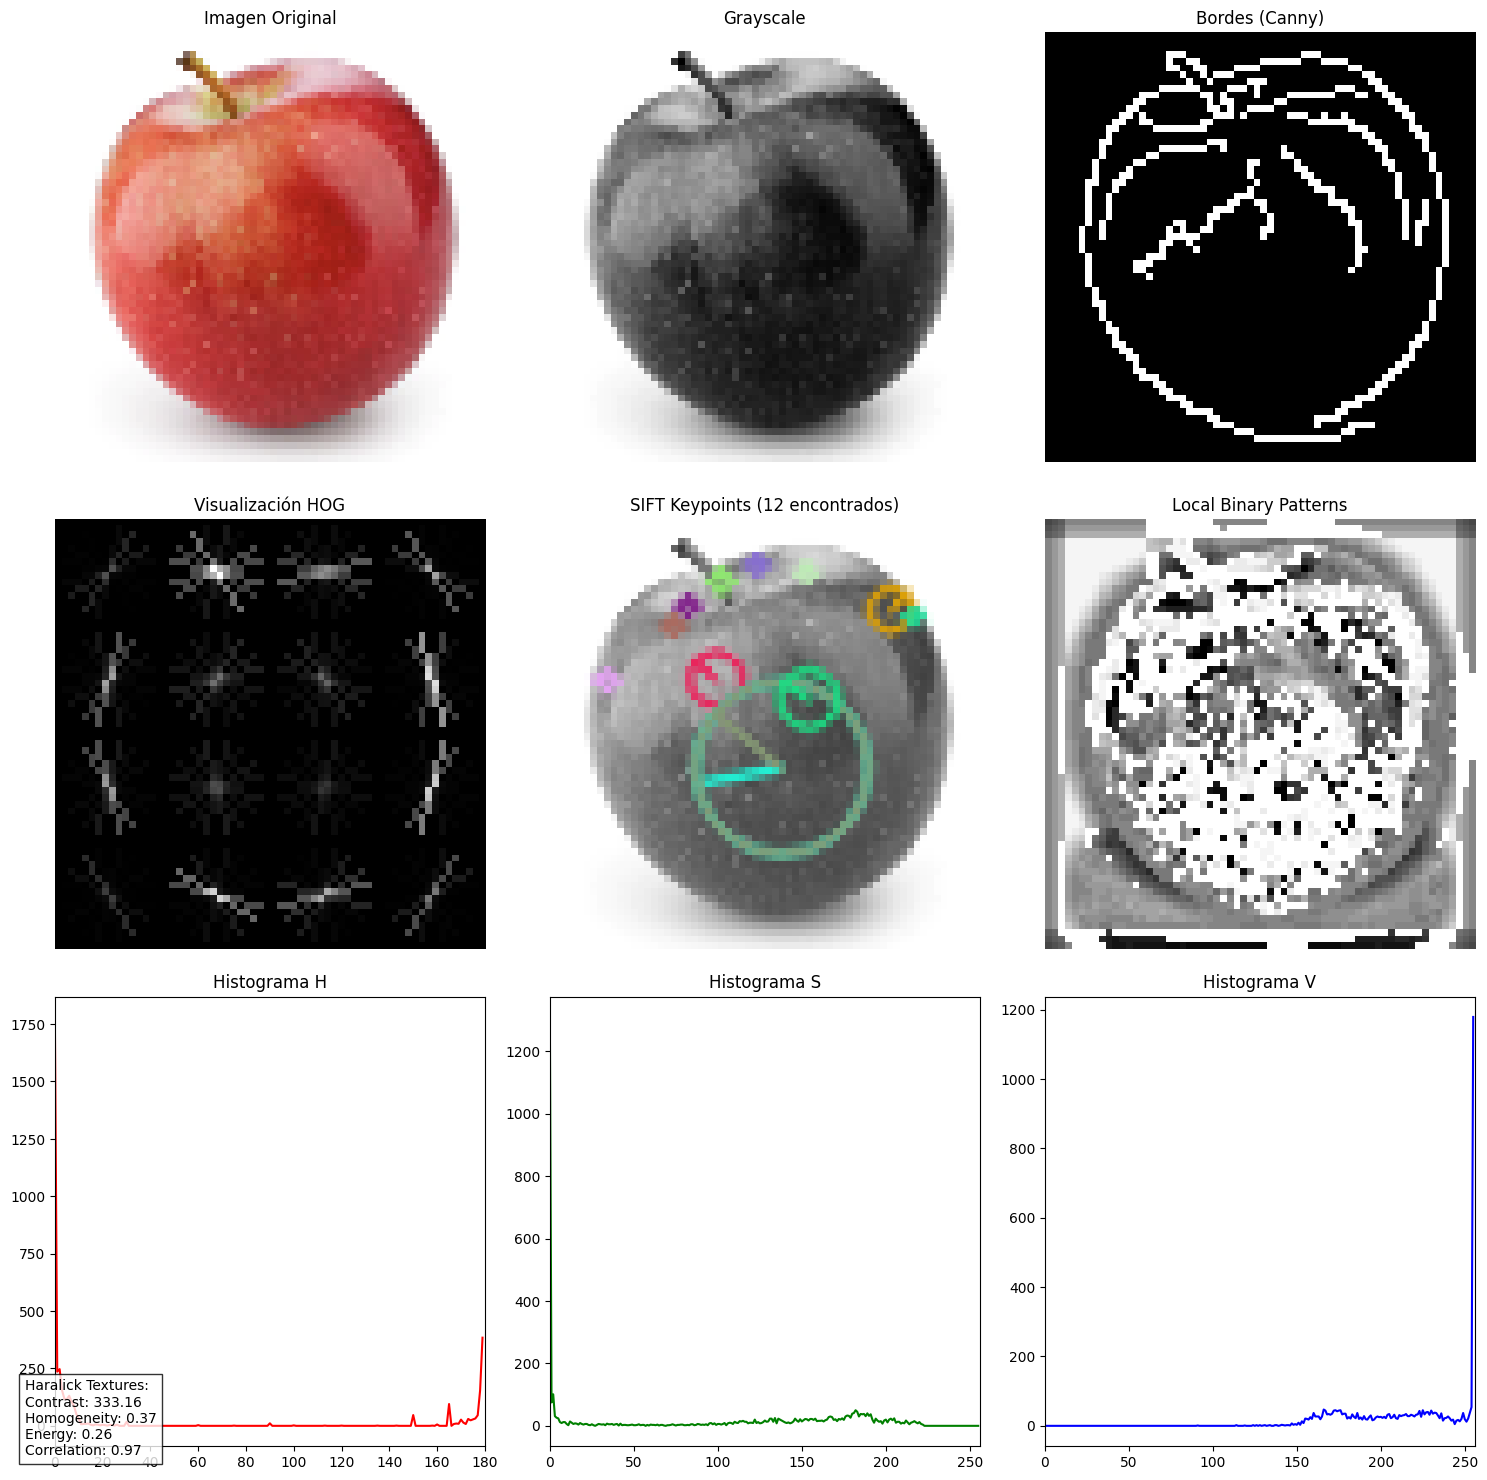

In [14]:
sample_image_path =  "/content/drive/MyDrive/Personal/Redes Neuronales Proyecto/Proyecto/Segunda entrega/Datasets/dataset/Apple__Healthy/vertical_flip_Screen Shot 2018-06-08 at 5.11.08 PM.png"
features = show_feature_extraction_steps(sample_image_path)
#TODO add feature visualization, more filters


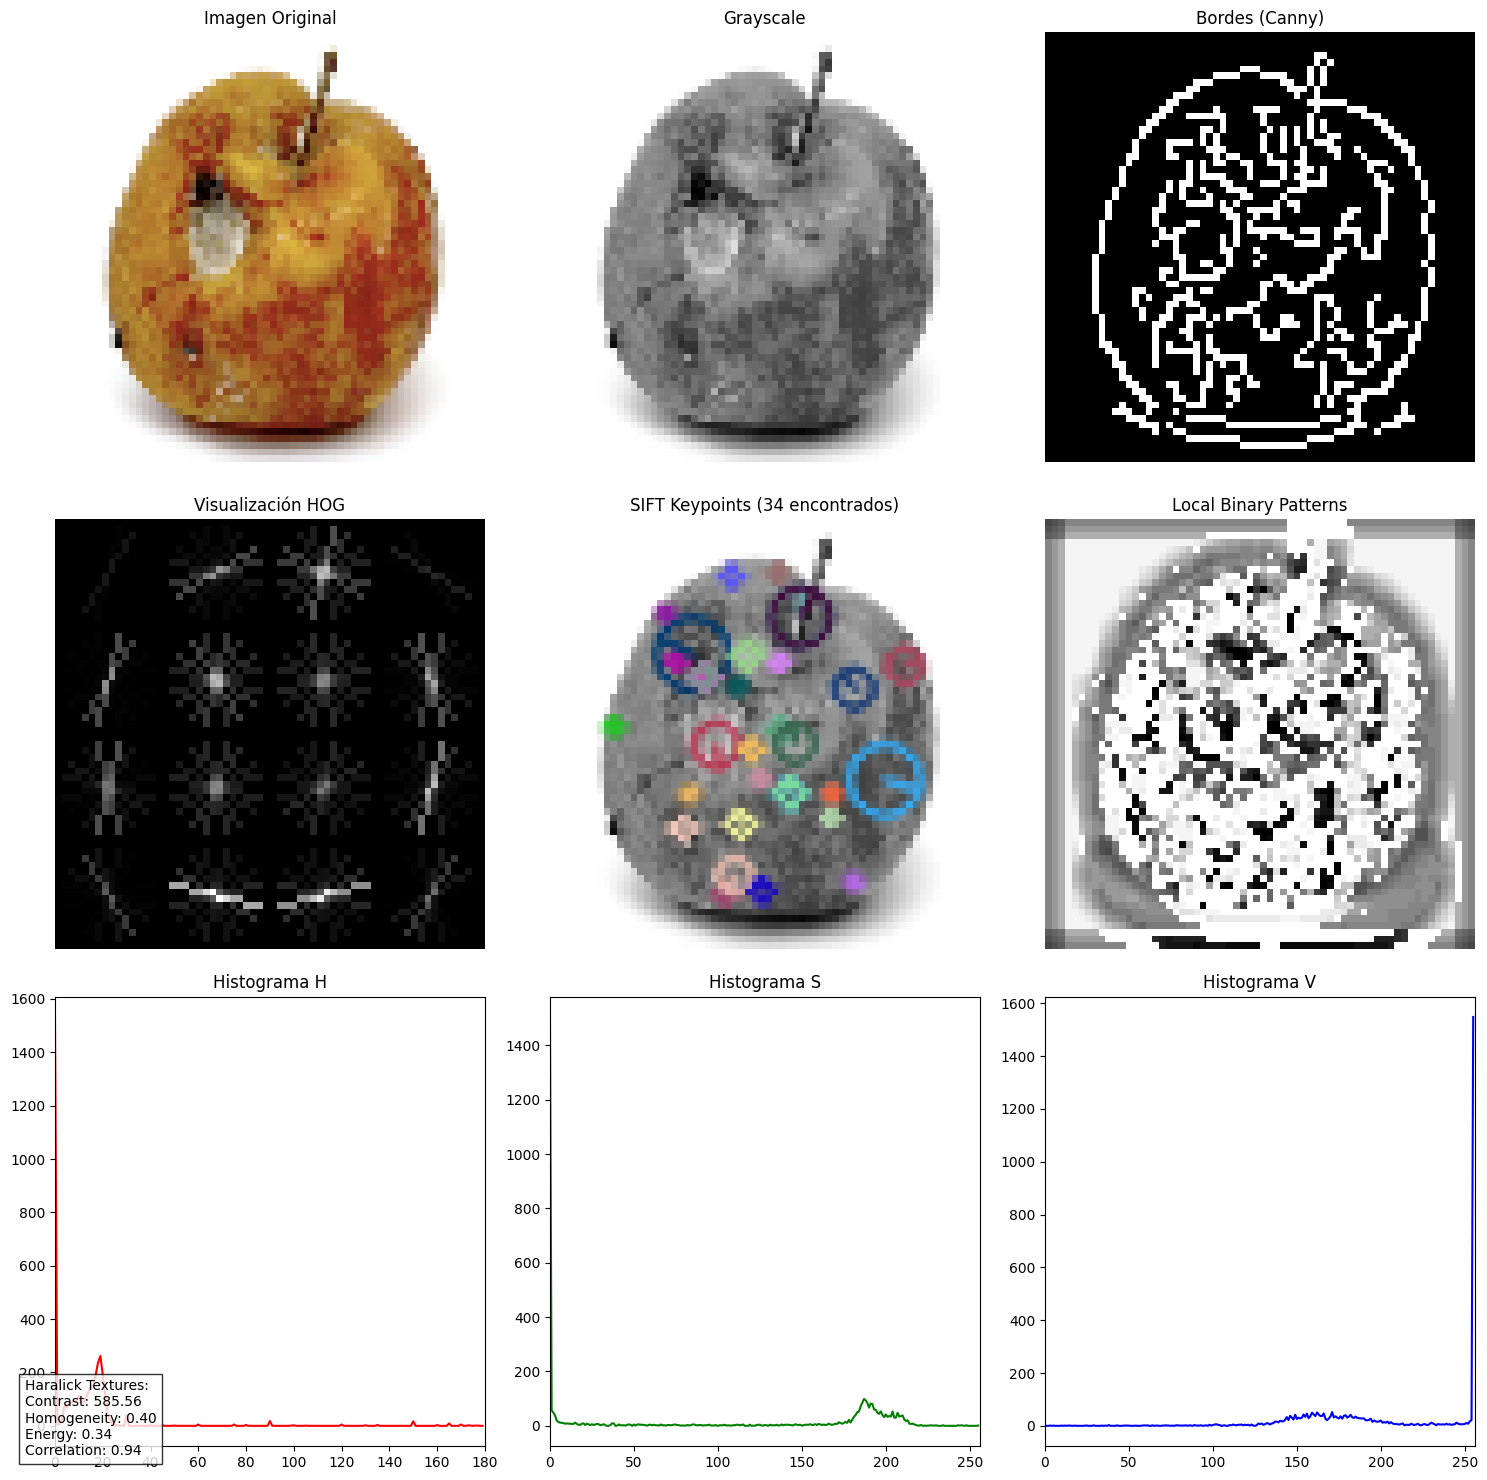

In [15]:
# sample_image_path = r"C:\Users\Usuario\Desktop\dataset1\Apple__Rotten\rottenApple (234).jpg"
sample_image_path = "/content/drive/MyDrive/Personal/Redes Neuronales Proyecto/Proyecto/Segunda entrega/Datasets/dataset/Apple__Rotten/vertical_flip_Screen Shot 2018-06-08 at 2.39.26 PM.png"
features = show_feature_extraction_steps(sample_image_path)


In [16]:
# -------------------------------
# Create Dataset (Features + Labels)
# -------------------------------
def create_feature_dataset(dataset_path):
    """
    Iterates over each subfolder corresponding to each class,
    extracts image features, and returns (DataFrame, labels).
    """
    features_list = []
    labels        = []

    for class_name in CLASSES:
        class_dir = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_dir):
            print(f"Warning: {class_dir} is not a valid directory!")
            continue

        for img_file in tqdm(os.listdir(class_dir)[:1000]):
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue  # skip non-image files

            img_path = os.path.join(class_dir, img_file)
            feats = extract_rot_features(img_path)

            # If extraction fails (None), skip
            if feats is None:
                continue

            features_list.append(feats)
            # Label: 1 for Rotten, 0 for Healthy
            label = 1 if "Rotten" in class_name else 0
            labels.append(label)

    df = pd.DataFrame(features_list)
    labels = np.array(labels)
    return df, labels


In [17]:
# -------------------------------
# Feature Selection
# -------------------------------
def fit_feature_selectors(X_train, y_train):
    """
    Fits variance, ANOVA, and Lasso selectors on training set.
    Combines their masks (union) into final_mask.
    """
    global variance_selector, anova_selector, lasso_selector, final_mask

    # 1) Variance Threshold
    variance_selector = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
    X_var = variance_selector.fit_transform(X_train)

    # 2) ANOVA
    # Make sure k <= number of features left after variance
    n_after_var = X_var.shape[1]
    k_for_anova = min(FEATURE_SELECTION_K, n_after_var)

    anova_selector = SelectKBest(f_classif, k=k_for_anova)
    X_anova = anova_selector.fit_transform(X_var, y_train)

    # 3) Lasso
    lasso_selector = LassoCV(cv=5, random_state=RANDOM_STATE)
    lasso_selector.fit(X_var, y_train)
    lasso_mask = (lasso_selector.coef_ != 0)

    # Combine ANOVA + Lasso in the space of X_var
    anova_mask = anova_selector.get_support()
    combined_mask = anova_mask | lasso_mask

    final_mask = combined_mask

def transform_features(X):
    """
    Apply the already-fitted variance_selector, then
    apply the union mask from ANOVA + Lasso.
    """
    # 1) Variance
    X_var = variance_selector.transform(X)
    # 2) Combined mask
    X_transformed = X_var[:, final_mask]
    return X_transformed


In [18]:
# -------------------------------
# Build & Compile Model
# -------------------------------
''' def create_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    return model '''

def create_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(input_dim,)),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    return model

100%|██████████| 1000/1000 [02:13<00:00,  7.49it/s]


Feature shape after selection: (1599, 115)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          14,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,217 (98.50 KB)

 Trainable params: 25,217 (98.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.5314 - loss: 3.2327 - precision: 0.5216 - recall: 0.5143 - val_accuracy: 0.7125 - val_loss: 2.7480 - val_precision: 0.7808 - val_recall: 0.6552
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6290 - loss: 2.7427 - precision: 0.6320 - recall: 0.5619 - val_accuracy: 0.7563 - val_loss: 2.4051 - val_precision: 0.7609 - val_recall: 0.8046
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6946 - loss: 2.4105 - precision: 0.6830 - recall: 0.6983 - val_accuracy: 0.8031 - val_loss: 2.0925 - val_precision: 0.8000 - val_recall: 0.8506
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7519 - loss: 2.0812 - precision: 0.7300 - recall: 0.7432 - val_accuracy: 0.8281 - val_loss: 1.8159 - val_precision: 0.7990 - val_recall: 0.9138
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7806 - loss: 1.8300 - precision: 0.7536 - recall: 0.8091 - val_accuracy: 0.8313 - val_loss: 1.5838 - va

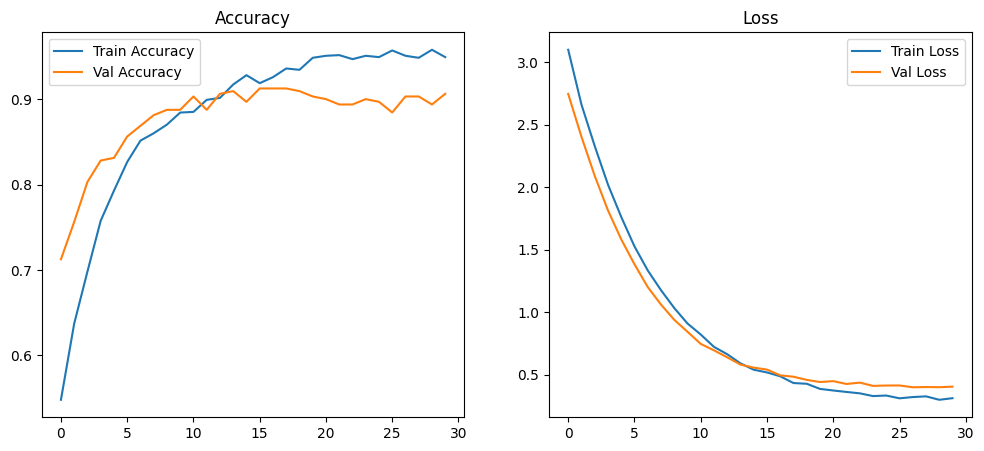

In [19]:
# -------------------------------
# Main Flow
# -------------------------------
# 1) Load & Extract Features
feature_df, labels = create_feature_dataset(DATA_PATH)

# 2) Handle NaNs
#   (Compute train mean after the train split, strictly speaking.
#    But for demonstration, we do a quick fillna on the entire DF.)
feature_df = feature_df.fillna(feature_df.mean())

# 3) Train/Test Split
X = feature_df.values
y = labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# 4) Scale the Data BEFORE Lasso (important!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 5) Fit Feature Selectors
fit_feature_selectors(X_train_scaled, y_train)

# 6) Transform with final mask
X_train_sel = transform_features(X_train_scaled)
X_test_sel  = transform_features(X_test_scaled)

print("Feature shape after selection:", X_train_sel.shape)

# 7) Build the Model
model = create_model(input_dim=X_train_sel.shape[1])
model.summary()

# 8) (Optionally) compute class_weights if data is imbalanced
counts = np.bincount(y_train)
if len(counts) == 2 and min(counts) != 0:
    total = len(y_train)
    class_weights = {
        0: (1.0 / counts[0]) * (total / 2.0),
        1: (1.0 / counts[1]) * (total / 2.0),
    }
else:
    class_weights = None

# 9) Train
''' history = model.fit(
    X_train_sel, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,  # can remove if not heavily imbalanced
    verbose=1
) '''

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_sel, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights
)

# 10) Evaluate
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()



In [20]:
# Test Set Metrics
y_pred = (model.predict(X_test_sel) > 0.5).astype("int32")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       200
           1       0.87      0.90      0.88       200

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400


Confusion Matrix:
[[173  27]
 [ 21 179]]


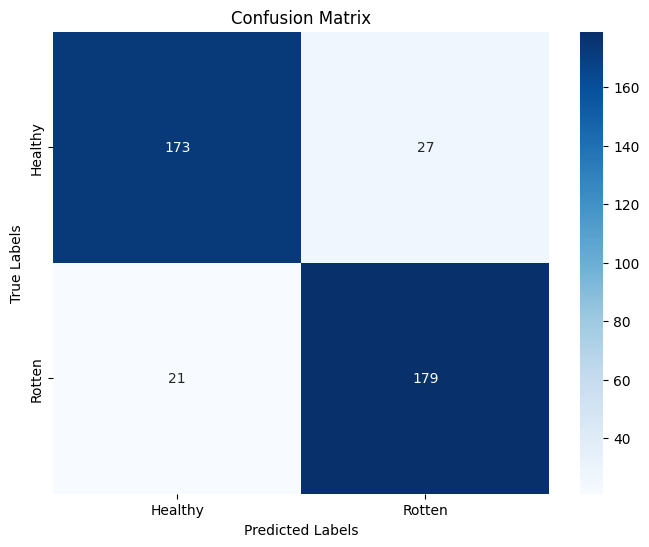

In [21]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plots a confusion matrix with Seaborn heatmap.
    Args:
        y_true: Ground truth labels.
        y_pred: Predicted labels.
        labels: List of label names for the matrix (e.g., ["Healthy", "Rotten"]).
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Llamada a la función después de realizar las predicciones
plot_confusion_matrix(y_test, y_pred, labels=["Healthy", "Rotten"])


In [22]:
def predict_apples(image_paths):
    """
    Predict if apple images are Rotten (1) or Healthy (0).
    Uses the existing pipeline + model.
    Displays the images with predictions and confidence levels.

    Args:
        image_paths (list): List of paths to apple images to predict

    Returns:
        list: List of tuples containing (prediction_label, confidence, image_path)
    """
    results = []

    # Create figure for displaying images and predictions
    n_images = len(image_paths)
    fig, axes = plt.subplots(1, n_images, figsize=(5*n_images, 5))
    if n_images == 1:
        axes = [axes]

    for idx, img_path in enumerate(image_paths):
        # Extract features
        features = extract_rot_features(img_path)
        if features is None:
            print(f"Could not process image: {img_path}")
            continue

        # Convert to DataFrame (single row)
        features_df = pd.DataFrame([features])

        # Fill NaN values with training mean
        features_df = features_df.fillna(features_df.mean())

        # Scale features
        X = scaler.transform(features_df.values)

        # Apply feature selection
        X_selected = transform_features(X)

        # Get prediction and confidence
        confidence = model.predict(X_selected)[0][0]
        prediction = 1 if confidence > 0.5 else 0

        # Store result
        results.append((prediction, confidence, img_path))

        # Display image with prediction
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))

        axes[idx].imshow(img)
        label = "Rotten" if prediction == 1 else "Healthy"
        color = "red" if prediction == 1 else "green"
        axes[idx].set_title(f"Prediction: {label}",
                          color=color)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    return results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


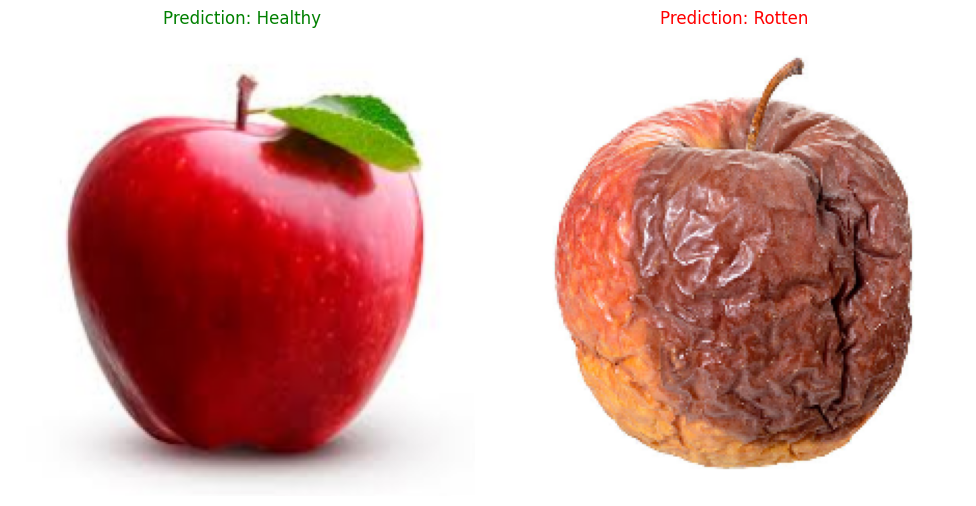

Image: /content/drive/MyDrive/Personal/Redes Neuronales Proyecto/Proyecto/Segunda entrega/Datasets/test/manzana_roja.jpg, Prediction: 0, Confidence: 0.0202
Image: /content/drive/MyDrive/Personal/Redes Neuronales Proyecto/Proyecto/Segunda entrega/Datasets/test/rotten.jpg, Prediction: 1, Confidence: 0.9928


In [23]:
test_images = [
    "/content/drive/MyDrive/Personal/Redes Neuronales Proyecto/Proyecto/Segunda entrega/Datasets/test/manzana_roja.jpg",
    "/content/drive/MyDrive/Personal/Redes Neuronales Proyecto/Proyecto/Segunda entrega/Datasets/test/rotten.jpg",
]

results = predict_apples(test_images)
for label, confidence, path in results:
    print(f"Image: {path}, Prediction: {label}, Confidence: {confidence:.4f}")